In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
test.iloc[0]

text        How do I locate my card?
category                card_arrival
Name: 0, dtype: object

# Aggregate text data and convert it into numerical format

In [5]:
# Aggregate text data by categories, and combine all sentences into one
aggregated_data = test.groupby("category")["text"].apply(lambda x: " ".join(x)).reset_index()

aggregated_data.head(5)

,category,text
0,Refund_not_showing_up,The refund isn't showing up on my account. My ...
1,activate_my_card,Could you please activate my card I need to ac...
2,age_limit,how old do i need to be to get an account for ...
3,apple_pay_or_google_pay,Is the top up feature available on the Apple W...
4,atm_support,Do all ATMs take this card? Which ATMs accept ...


In [6]:
# Convert aggregated text data into numerical format using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(aggregated_data["text"])

# Find the best number of clusters

In [7]:
# Define the range of clusters to try
range_n_clusters = list(range(2, 15))

elbow_values = []
silhouette_scores = []

for n_clusters in range_n_clusters:
    model = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = model.fit_predict(X)

    # A higher silhouette score indicates that the clusters are well apart from each other
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

    # The total intra-cluster variation
    elbow_values.append(model.inertia_)

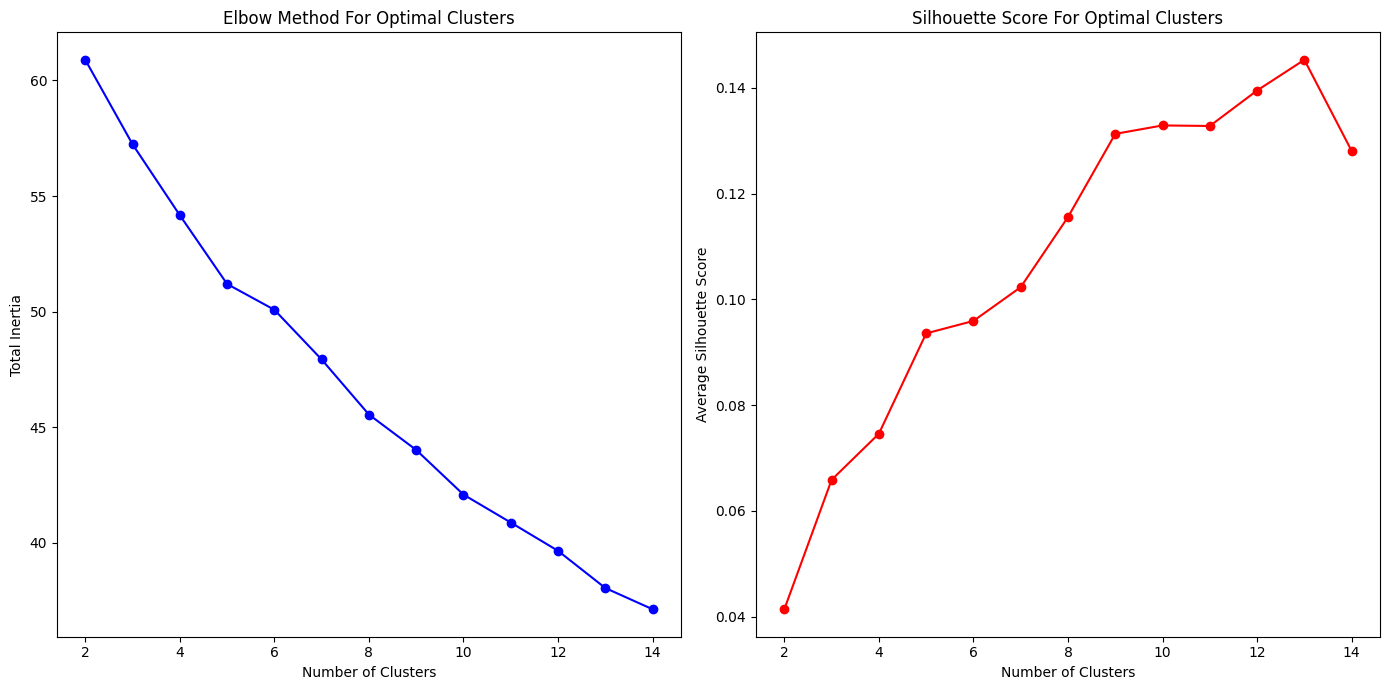

In [8]:
# Plotting the Elbow Curve
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, elbow_values, "bo-")
plt.title("Elbow Method For Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Total Inertia")

# Plotting the Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_scores, "ro-")
plt.title("Silhouette Score For Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Score")

plt.tight_layout()
plt.show()

The "elbow" is not very distinct; however, there appears to be a slight bend at around 6 clusters. For the Silhouette Score graph, there is a small peak at 6 clusters. They indicate that it could be a reasonable number of clusters to try.

# Create six different clusters

In [9]:
# Clustering with K-means
num_topics = 6 # From the elbow curve and silhouette score
kmeans = KMeans(n_clusters=num_topics, random_state=42)
aggregated_data["topic"] = kmeans.fit_predict(X)

aggregated_data.head(5)

,category,text,topic
0,Refund_not_showing_up,The refund isn't showing up on my account. My ...,5
1,activate_my_card,Could you please activate my card I need to ac...,2
2,age_limit,how old do i need to be to get an account for ...,4
3,apple_pay_or_google_pay,Is the top up feature available on the Apple W...,4
4,atm_support,Do all ATMs take this card? Which ATMs accept ...,2


In [10]:
# Merge the topic labels back to the original dataset
merged = test.merge(aggregated_data[["category", "topic"]], on="category")

topic_categories = merged.groupby("topic")["category"].unique().reset_index()

In [11]:
# Loop over each cluster number and its corresponding categories
clusters = {}

for i in range(len(topic_categories)):
    # Get the list of categories for this topic
    categories = topic_categories["category"].iloc[i].tolist()

    # Assign this list to the appropriate cluster number in the dictionary
    clusters[i+1] = categories

# This dictionary can be used to map clusters back to the original test dataset later
clusters

{1: ['exchange_rate',
  'card_payment_wrong_exchange_rate',
  'fiat_currency_support',
  'exchange_via_app',
  'receiving_money',
  'wrong_exchange_rate_for_cash_withdrawal',
  'exchange_charge'],
 2: ['top_up_by_bank_transfer_charge',
  'cancel_transfer',
  'transfer_not_received_by_recipient',
  'declined_transfer',
  'pending_transfer',
  'transfer_timing',
  'beneficiary_not_allowed',
  'transfer_fee_charged',
  'failed_transfer',
  'transfer_into_account',
  'balance_not_updated_after_bank_transfer'],
 3: ['card_arrival',
  'card_linking',
  'card_delivery_estimate',
  'card_not_working',
  'lost_or_stolen_card',
  'getting_virtual_card',
  'card_acceptance',
  'get_physical_card',
  'visa_or_mastercard',
  'disposable_card_limits',
  'compromised_card',
  'atm_support',
  'card_swallowed',
  'getting_spare_card',
  'order_physical_card',
  'virtual_card_not_working',
  'get_disposable_virtual_card',
  'activate_my_card',
  'card_about_to_expire',
  'country_support'],
 4: ['why_v

Cluster 1: Exchange and currency services

This cluster is related to foreign currency exchange services. It includes categories related to exchange rates, payment issues regarding exchange rates, support for fiat currencies, and charges related to exchange services.

Cluster 2: Transfer issues

This cluster is related to money transfers. This includes charges for bank transfers, problems with transfers not being received, transfer cancellations, and issues with transfer timing.

Cluster 3: Card services

This cluster is related to a wide range of services and issues related to both physical and virtual cards. It includes card delivery, card functioning, loss or theft of cards, and card activation.

Cluster 4: Identity verification

This cluster is quite specific and seems to deal with the process of identity verification.

Cluster 5: Account and top-up services

This cluster is related to general account services and the action of adding funds to an account (topping up). It includes automatic top-up services, age-related limits, top-up methods, and changes to personal account details.

Cluster 6: Charges and transaction issues

This cluster is related to various charges that customers encounter and problems with transactions. This includes unexpected charges on statements, issues with cash withdrawals, and problems with transactions being recognized or processed correctly.


In [12]:
# Reduce the dimensionality of the TF-IDF features
pca = PCA(n_components=2, random_state=42)
X_reduced = pca.fit_transform(X.toarray()) # Convert sparse matrix to dense

# Add the reduced dimensions to the previously processed dataset
aggregated_data["pca_x"] = X_reduced[:, 0]
aggregated_data["pca_y"] = X_reduced[:, 1]

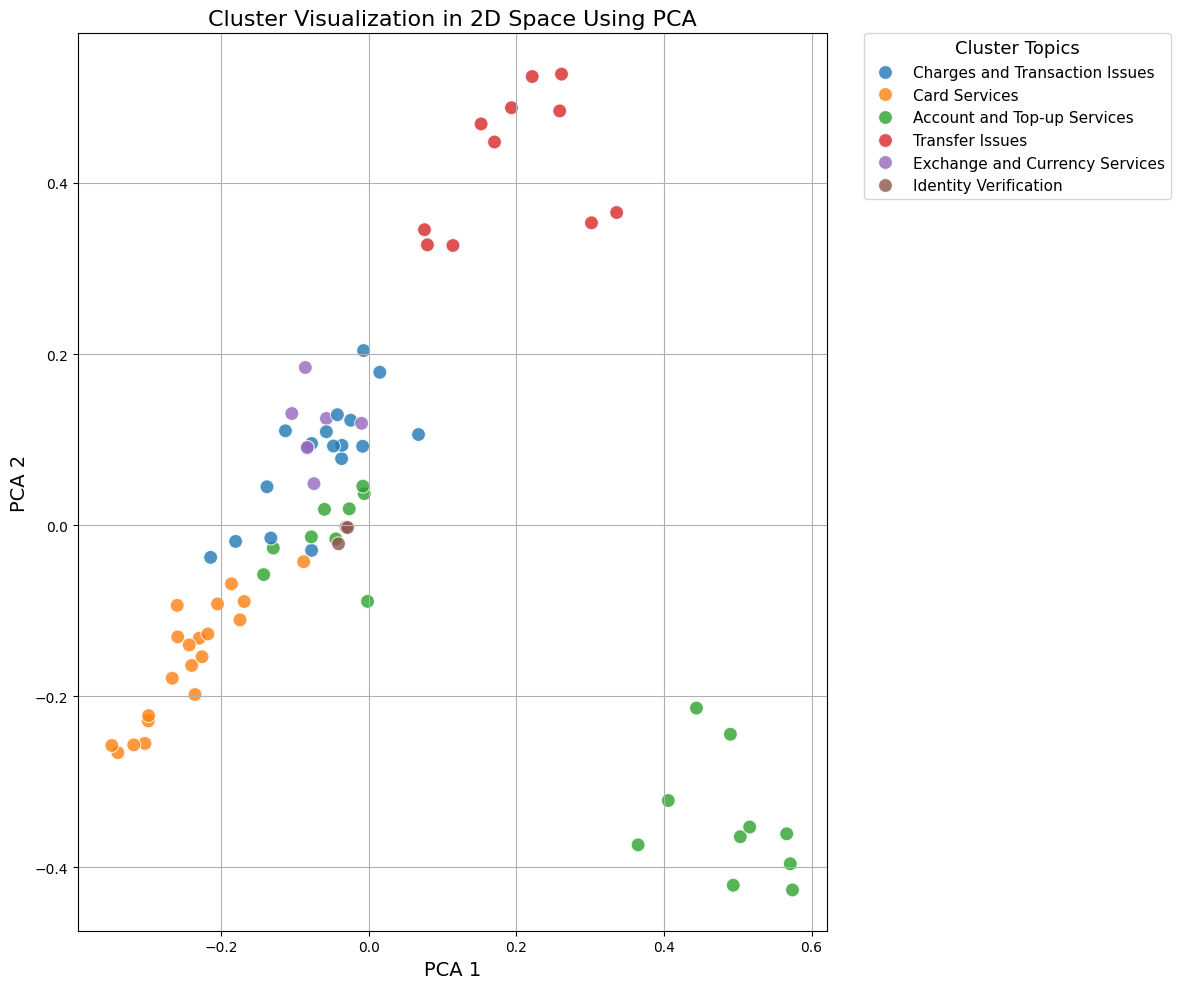

In [13]:
plt.figure(figsize=(12, 10))

cluster_descriptions = {
    0: "Exchange and Currency Services",
    1: "Transfer Issues",
    2: "Card Services",
    3: "Identity Verification",
    4: "Account and Top-up Services",
    5: "Charges and Transaction Issues"
}

aggregated_data["cluster_description"] = aggregated_data["topic"].map(cluster_descriptions)

sns.scatterplot(x="pca_x", y="pca_y", hue="cluster_description", data=aggregated_data,
                palette="tab10", legend="full", alpha=0.8, s=100)

plt.title("Cluster Visualization in 2D Space Using PCA", fontsize=16)
plt.xlabel("PCA 1", fontsize=14)
plt.ylabel("PCA 2", fontsize=14)

plt.legend(title="Cluster Topics", title_fontsize="13", fontsize="11",
           bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)

plt.grid(True)
plt.tight_layout()
plt.show()

# Check the accuracy score within each cluster

In [14]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# BERT-Banking77 model
model_id = 'philschmid/BERT-Banking77'
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(model_id)
classifier = pipeline('text-classification', tokenizer=tokenizer, model=model)
classifier('What is the base of the exchange rates?')

tokenizer_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/5.95k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

[{'label': 'exchange_rate', 'score': 0.9740924835205078}]

In [15]:
# Invert the dictionary so that each category maps to its cluster number
category_to_cluster = {
    category: cluster for cluster, categories in clusters.items()
    for category in categories
    }

# Map the cluster number back to the test dataset
test["topic"] = test["category"].map(category_to_cluster)

test.head(5)

,text,category,topic
0,How do I locate my card?,card_arrival,3
1,"I still have not received my new card, I order...",card_arrival,3
2,I ordered a card but it has not arrived. Help ...,card_arrival,3
3,Is there a way to know when my card will arrive?,card_arrival,3
4,My card has not arrived yet.,card_arrival,3


In [16]:
# Run the model on the entire testing set
results = []

for index, row in test.iterrows():
    text = row["text"]
    topic = row["topic"]
    prediction = classifier(text)

    # Create a result dictionary with those values below
    results.append({
        "text": text, # Storing the text for reference
        "topic": topic, # Storing the topic for future groupby
        "true_category": row["category"], # Storing the true category
        "predicted_label": prediction[0]["label"], # Storing the predicted label
        "score": prediction[0]["score"] # Storing the score of the prediction
    })

In [17]:
# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Calculate whether the prediction was correct
results_df["is_correct"] = results_df["true_category"] == results_df["predicted_label"]

# Calculate the accuracy per topic
accuracy_per_topic = results_df.groupby("topic")["is_correct"].mean()

In [18]:
accuracy_per_topic

topic
1    0.928571
2    0.865909
3    0.930000
4    0.941667
5    0.940789
6    0.947059
Name: is_correct, dtype: float64

As we can see, the average accuracy among all clusters (topics) is very similar. Cluster 2, transfer issues, has the lowest accuracy score, approximately 0.87.

In [19]:
transfer_issues = results_df[results_df["topic"] == 2]

# Identify rows with incorrect predictions
incorrect_predictions = transfer_issues[transfer_issues["is_correct"] == False]

# All true categories which don't match with their predicted values
incorrect_predictions["true_category"].unique()

array(['top_up_by_bank_transfer_charge', 'cancel_transfer',
       'transfer_not_received_by_recipient', 'declined_transfer',
       'pending_transfer', 'transfer_timing', 'beneficiary_not_allowed',
       'transfer_fee_charged', 'failed_transfer', 'transfer_into_account',
       'balance_not_updated_after_bank_transfer'], dtype=object)

After extracting elements from Cluster 2 and reviewing the incorrect ones, we can identify which categories do not match their predicted values.

Questions from Joyce:

*   How can I check whether this clustering function can enhance the overall accuracy of the model? Could you please provide some hints on that?

*   After finding the average accuracy for each cluster, what steps should I take next?